In [1]:
import os
import keras
import random
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_probability as tfp
from tensorflow.keras.backend import clear_session
from tensorflow_probability import distributions as tfd
import functions.functions as funs

# Set the random generators for reproducibility.
os.environ['PYTHONHASHSEED']=str(12345)
random.seed(12345)
rng = np.random.default_rng(12345)
tf.random.set_seed(12345)

# Configure a new global `tensorflow` session:
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

2023-02-28 20:27:52.781682: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
wine = pd.read_csv("../Data/wine.csv")

In [3]:
y = wine.type.astype('object').tolist()
X = wine.drop('type', axis=1)

In [4]:
X_train, X_test, X_valid, y_train, y_test, y_valid = funs.transform(X, y, 3, 'classifier')

Classification

In [5]:
kl_weight = 1 / X_train.shape[0]

In [6]:
metric = [tf.keras.metrics.Accuracy(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]

### 1. Standard Neural Network Classifier

In [7]:
clear_session

inputs = tf.keras.Input(shape=(X_train.shape[1], ))
features = keras.layers.Dense(16, activation='elu')(inputs)
features = keras.layers.Dense(16, activation='elu')(features)
probabilities = keras.layers.Dense(3, activation='softmax')(features)
categories = tfp.layers.OneHotCategorical(3)(probabilities)

model = keras.Model(inputs=inputs, outputs=probabilities)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005), loss='categorical_crossentropy', metrics=metric)
history = model.fit(X_train, y_train, epochs=500, validation_data=(X_valid, y_valid), batch_size=512, verbose=0)
metrics = model.evaluate(X_test, y_test, verbose=0)

In [8]:
funs.metrics_printer(metrics, machine='class')

TEST METRICS
catcrossent 	 1.09 
Accuracy 	 0.65 
Precison 	 0.63 
Recall  	 0.94


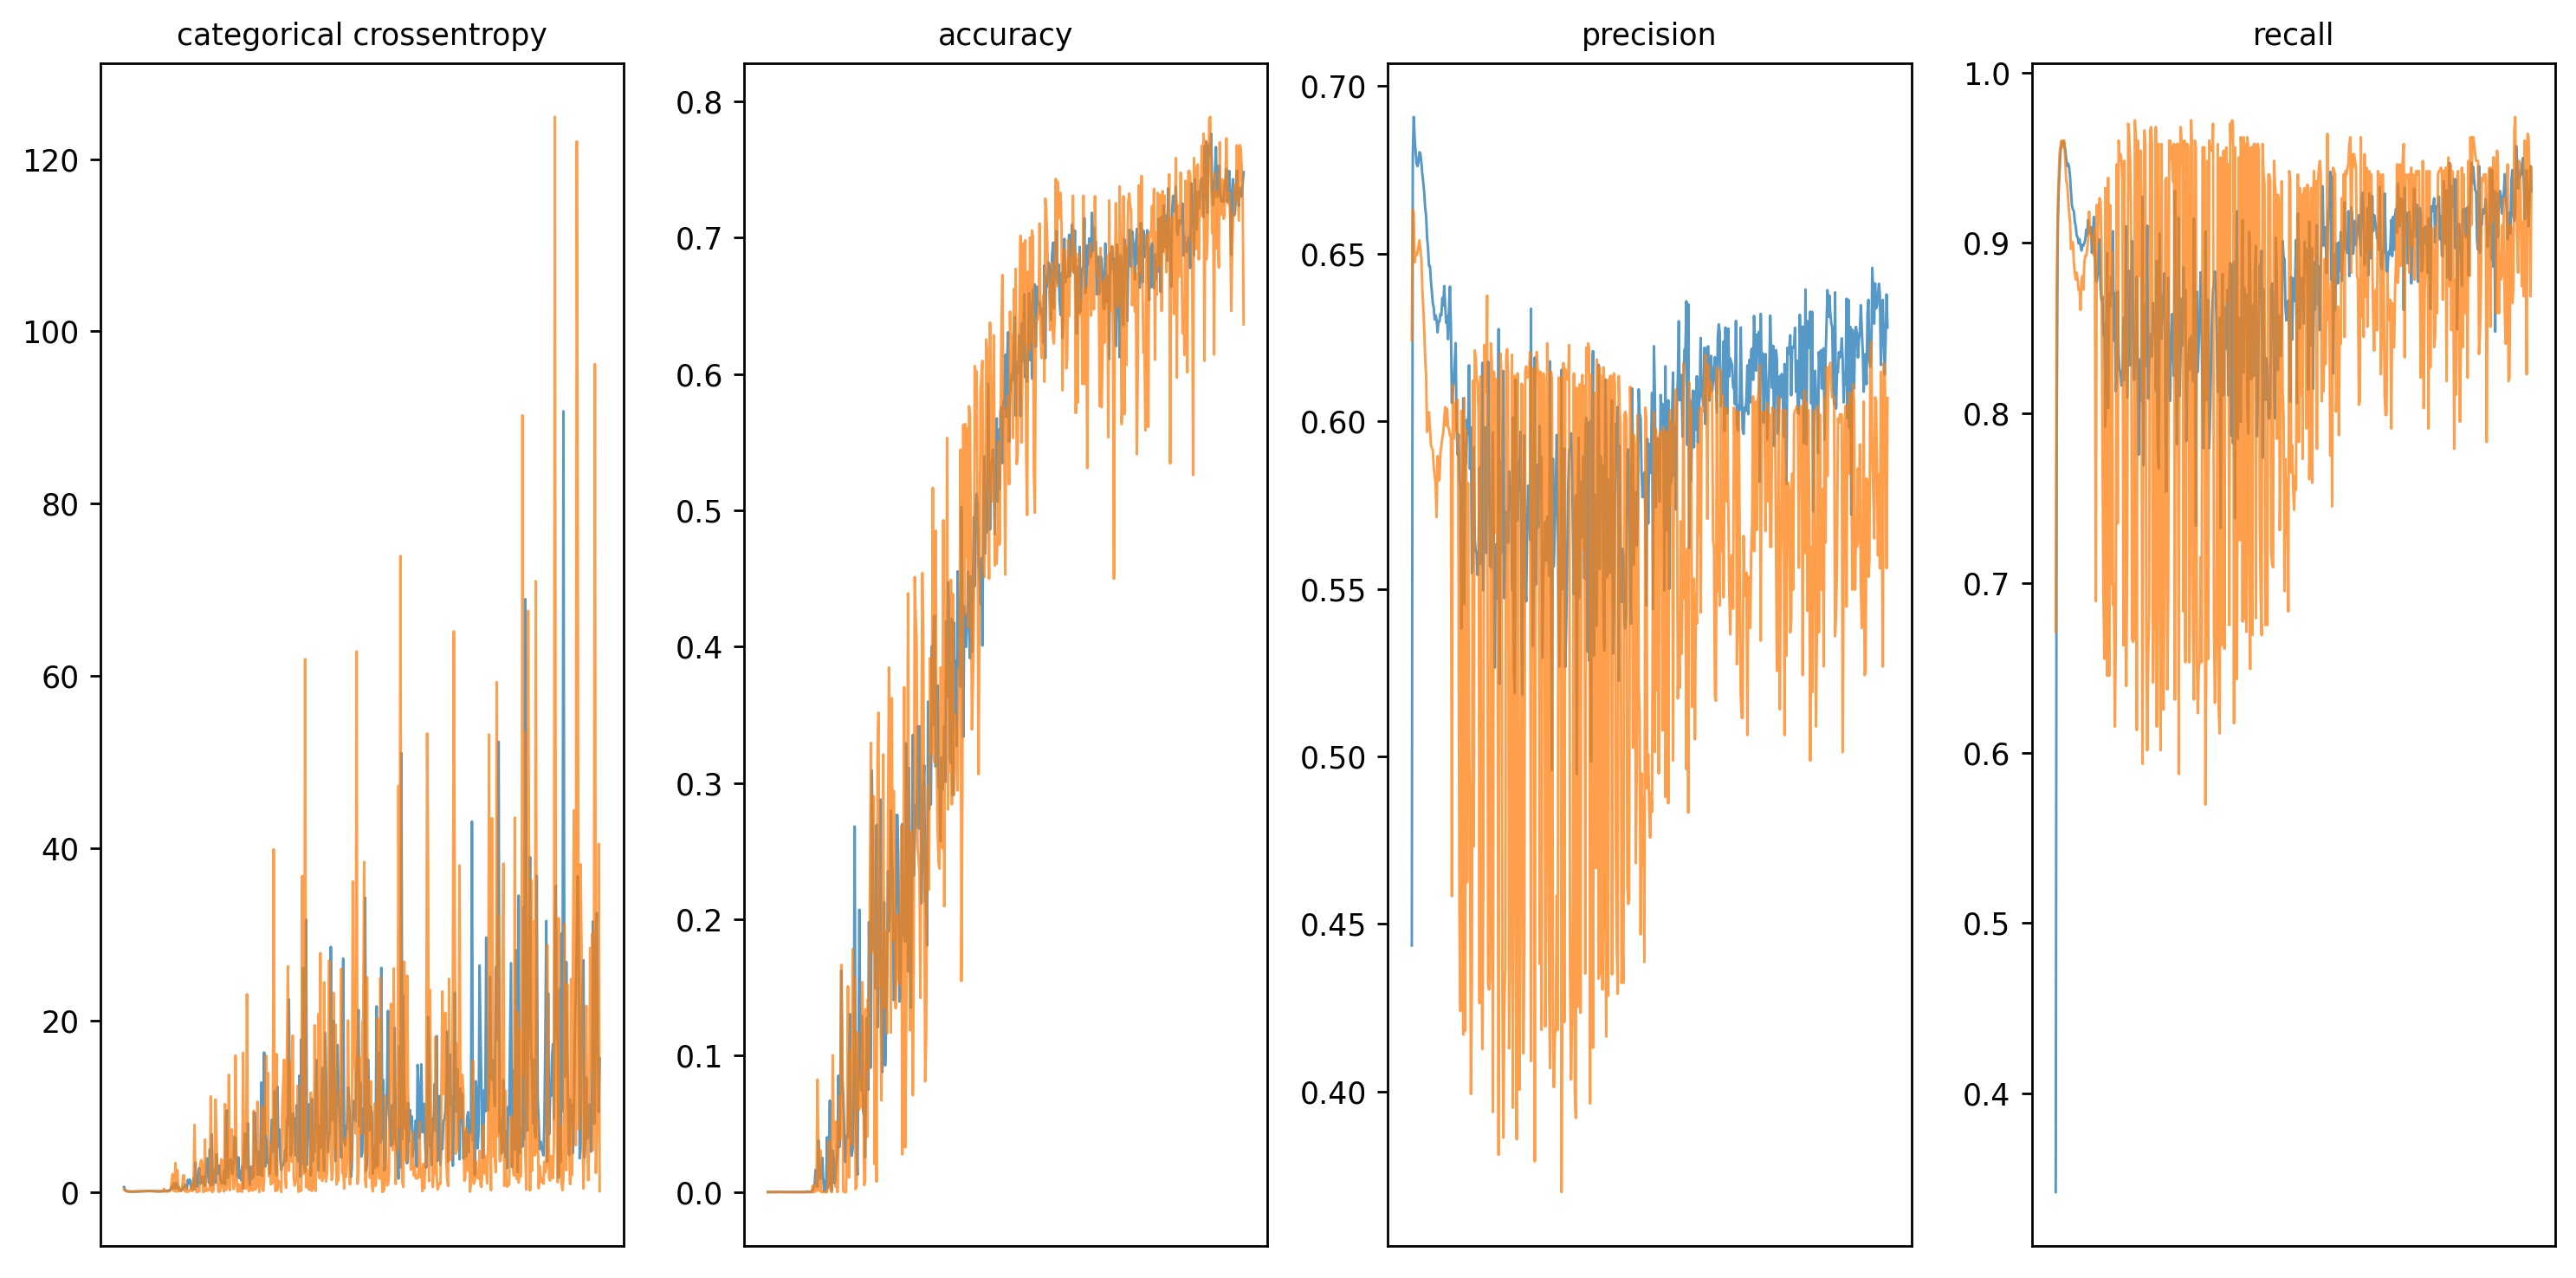

In [9]:
funs.plt_params(250, 12, 6)
funs.metrics_plotter(history, ['loss','accuracy','precision','recall'], 'categorical crossentropy')

## Introducing Probabilistic Deep Learning

#### Negative log(Likelihood)

In [10]:
def negloglike(targets, estimated_distribution):        
    return -estimated_distribution.log_prob(targets)

Add Categorical Cross Entropy

In [11]:
metric = [tf.keras.metrics.CategoricalCrossentropy(), tf.keras.metrics.Accuracy(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]

### 2. Porbabilistic Neural Network Classifier

In [12]:
clear_session

inputs = tf.keras.Input(shape=(X_train.shape[1], ))
features = keras.layers.Dense(16, activation='elu')(inputs)
features = keras.layers.Dense(16, activation='elu')(features)
probabilities = keras.layers.Dense(3, activation='softmax')(features)
distributions = tfp.layers.DistributionLambda(lambda p: tfd.Categorical(probs=p))(probabilities)
categories = tfp.layers.OneHotCategorical(3)(probabilities)

model = keras.models.Model(inputs=inputs, outputs=categories)
probs = keras.models.Model(inputs=inputs, outputs=probabilities)
distb = keras.models.Model(inputs=inputs, outputs=distributions)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005), loss=negloglike, metrics=metric)
history = model.fit(X_train, y_train, epochs=500, validation_data=(X_valid, y_valid), batch_size=512, verbose=0)
metrics = model.evaluate(X_test, y_test, verbose=0)

In [13]:
funs.metrics_printer(metrics, machine='class', p=True)

TEST METRICS
negloglike 	 0.37 
catcrossent 	 4.62 
Accuracy 	 0.70 
Precison 	 0.38 
Recall  	 0.57


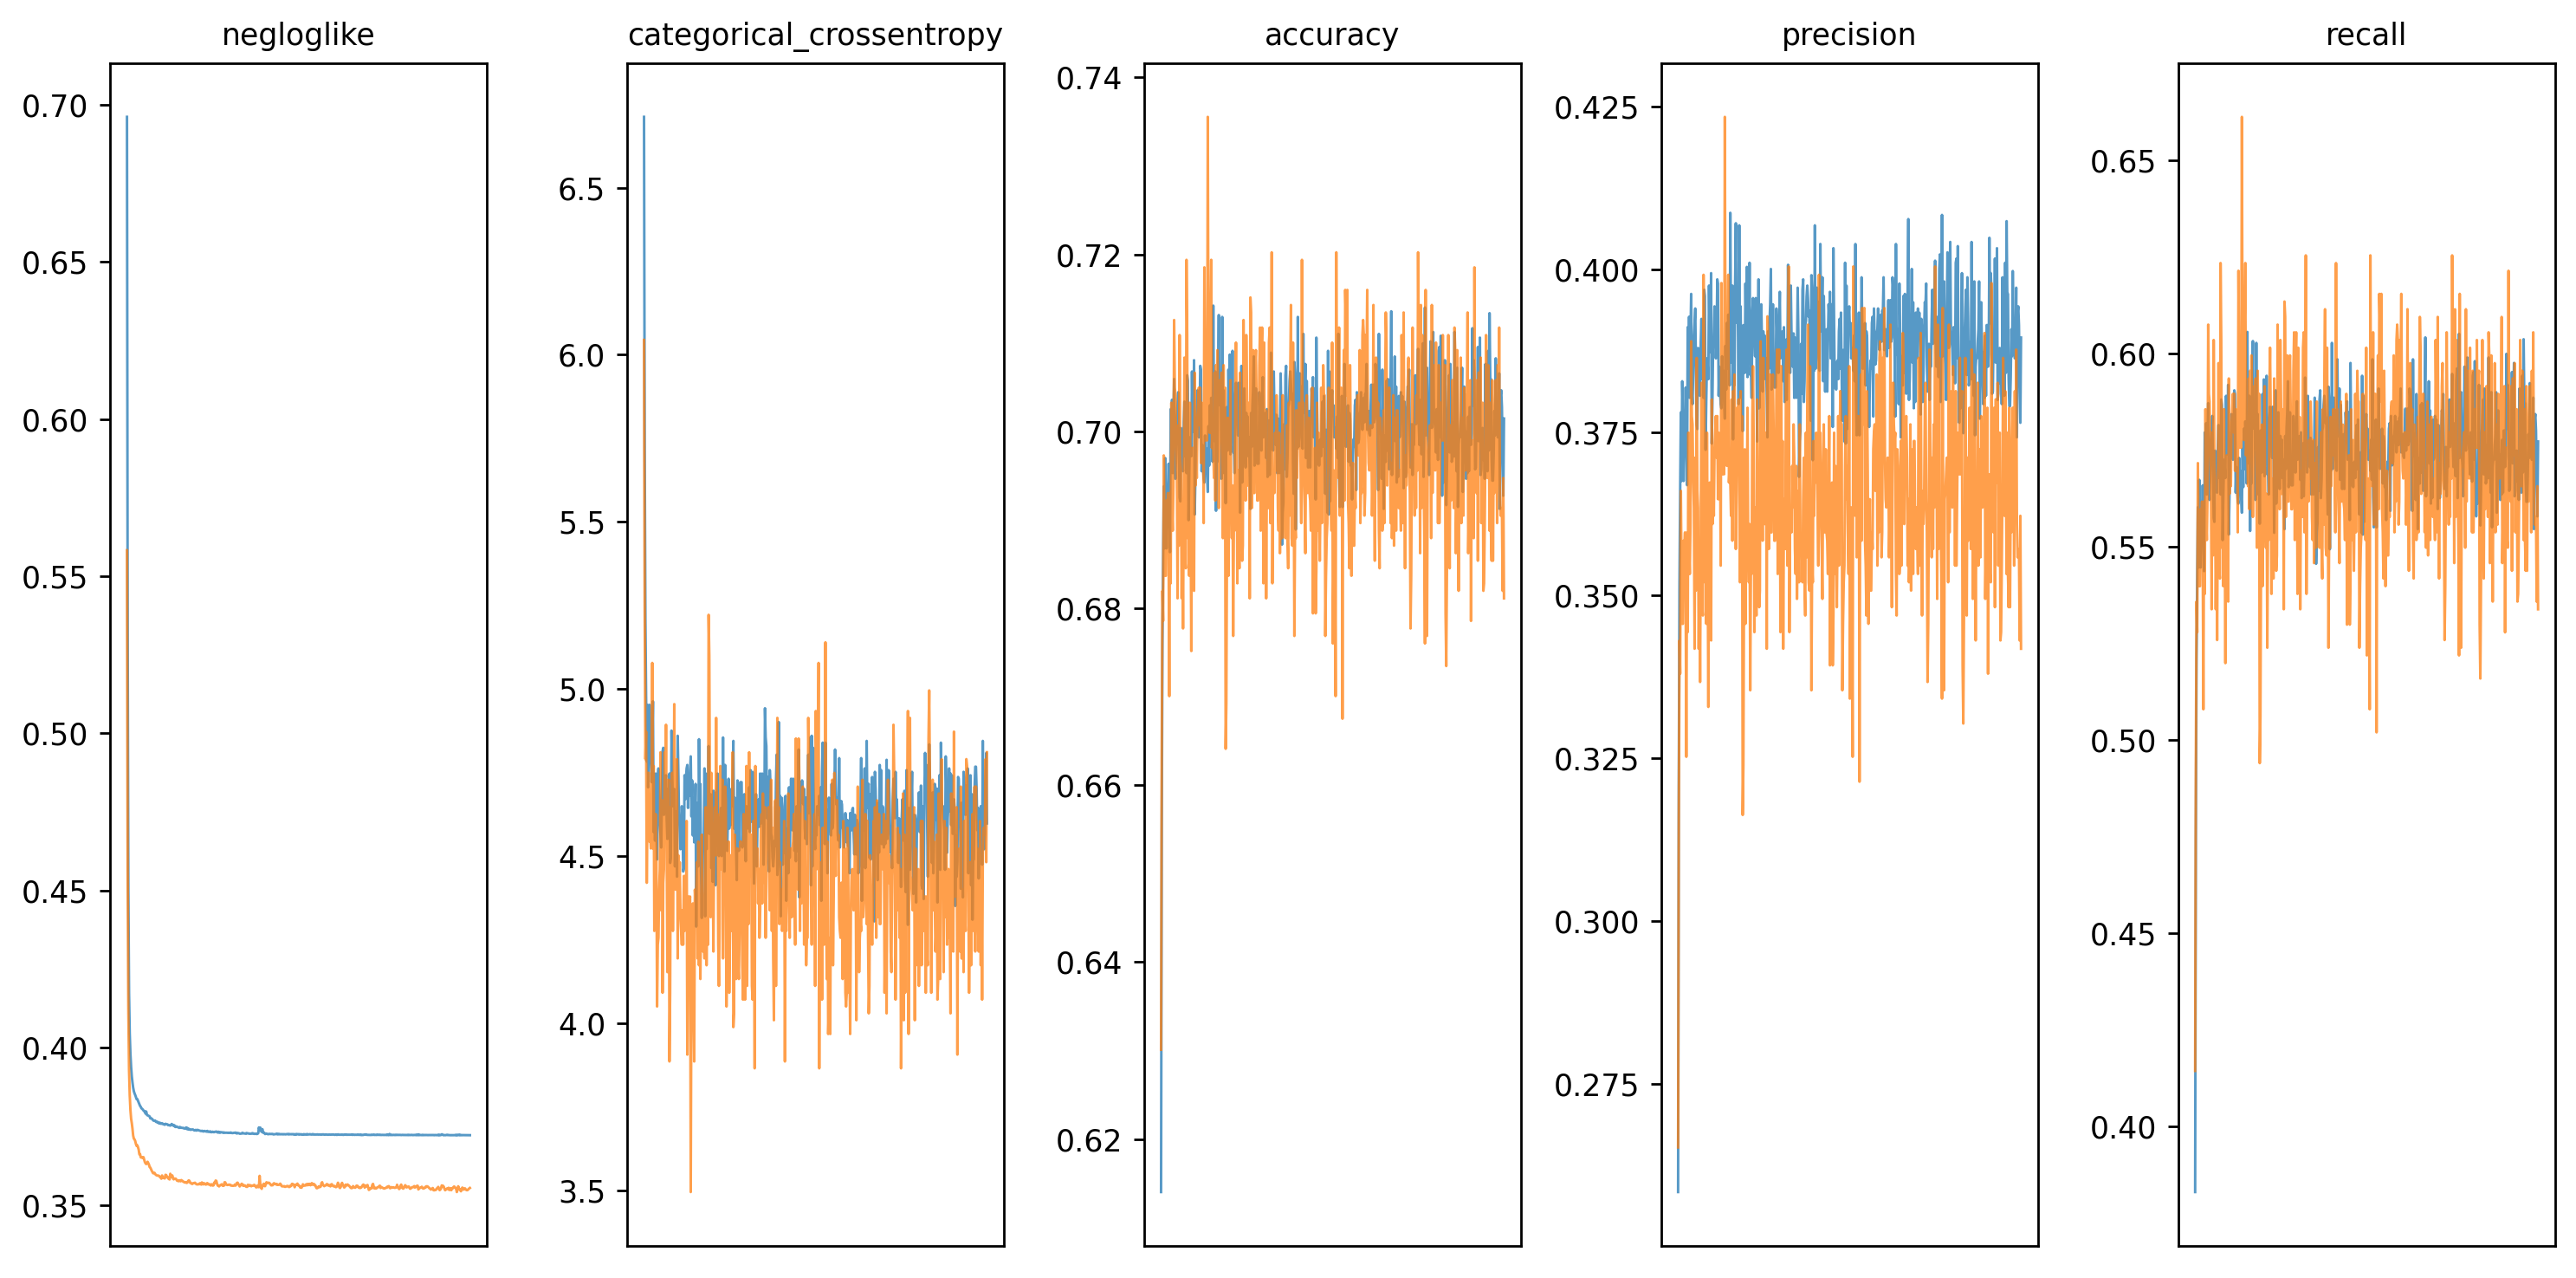

In [14]:
funs.metrics_plotter(history, ['loss','categorical_crossentropy','accuracy','precision','recall'], loss='negloglike')

In [ ]:
test = X_test[0].reshape(1, len(X_train[0]))

In [ ]:
pros = []
dist = []
cats = np.array([0.0, 0.0, 0.0])

for i in range(0,1000):

    cats = cats + model(test).sample().numpy()[0]
    pros.append(probs(X_test)[0:1].numpy()[0].tolist())
    dist.append(distb(X_test).sample().numpy()[0])

## Introducing Bayesian Deep Learning

#### Prior Distribution 
$$\pi \left ( \mathbf{W} \right) \sim \mathrm{N} \left( 0, 1 \right)$$

In [21]:
def prior_fn(kernel_size, bias_size, dtype=None):
    # Define the prior weight distribution as Normal(0, 1).
    # The prior is not trainable as the parameters are fixed.
    n = kernel_size + bias_size
    prior = keras.Sequential([
                tfp.layers.DistributionLambda(lambda t: 
                    tfp.distributions.MultivariateNormalDiag(loc=tf.zeros(n), scale_diag=tf.ones(n))),
        ])

    return prior

$$\pi \left ( \mathbf{W} \right) \sim \mathrm{N} \left( \mu, 1 \right)$$

In [16]:
def prior_two(kernel_size, bias_size=0, dtype=None):
    # Define the prior weight distribution as Normal(Xn, 1).
    # The prior is has trainable mean based on the data.
    n = kernel_size + bias_size
    prior = tf.keras.Sequential([
                tfp.layers.VariableLayer(n, dtype=dtype),
                tfp.layers.DistributionLambda(lambda t: 
                    tfd.Independent(tfd.Normal(loc=t, scale=1), reinterpreted_batch_ndims=1)),
    ])

    return prior 

#### Posterior Distribution 

$$P \left( \mathbf{w} \mid \mathcal{D} \right) \sim \mathcal{N}_k \left( \bar{\mu}, \: \bar{\Sigma} \right)$$

$$ \bar{\mu} = \mathbb{E} \left[ \mathbf{X} \right] = \left( \mathbb{E}[X_1], \; \mathbb{E}[X_1], \; ..., \; \mathbb{E}[X_k] \right)$$

In [17]:
def posterior_fn(kernel_size, bias_size, dtype=None):
    # Define variational posterior weight distribution as multivariate Gaussian.
    # Note that the learnable parameters for this distribution are the means, variances, and covariances.
    n = kernel_size + bias_size
    posterior = keras.Sequential([
                    tfp.layers.VariableLayer(
                        tfp.layers.MultivariateNormalTriL.params_size(n), dtype=dtype), 
                        tfp.layers.MultivariateNormalTriL(n),
    ])
    return posterior

$$P \left( \mathbf{w} \mid \mathcal{D} \right ) \sim \mathrm{N} \left( \mu_{\mathbf{x}},  \sigma^{2}_{\mathbf{x}} \right)$$


$$ \mu_x = \mathbb{E} \left [ \mathbf{\hat{y}} \mid \mathbf{x},\mathbf{w} \right ] = \mathbf{xw}$$

In [18]:
def posterior_two(kernel_size, bias_size=0, dtype=None):
    # Specify the surrogate posterior over `keras.layers.Dense` `kernel` and `bias`.
    n = kernel_size + bias_size
    c = np.log(np.expm1(1.))
    posterior =  tf.keras.Sequential([
                    tfp.layers.VariableLayer(2 * n, dtype=dtype),
                    tfp.layers.DistributionLambda(lambda t: 
                        tfd.Independent(tfd.Normal(loc=t[..., :n], scale=1e-5 + tf.nn.softplus(c + t[..., n:])), 
                        reinterpreted_batch_ndims=1)),

    ])

    return posterior

### 4. Unknown Unkowns: The *Epistemic Uncertainty*

Bayesian Neural Network

Instead of learning deterministic weights – and bias – , the Bayesian approach learns the weights' distributions - from which it can be sampled to produce an output for a given dataset.

$$P \left( \mathbf{w} \mid \mathcal{D} \right) = \frac{ \mathrm{f} \left( \mathcal{D} \mid \mathbf{w} \right) \pi (\mathbf{w})}{P \left( \mathcal{D} \right)} $$

The weights' prior and posterior distributions need to be defined – the neural network learns the parameters of these distirbutions. If the the parameters are fixed, the prior is not trainable.

$$\pi (\mathbf{w}) \sim \mathrm{N} \left( 0,1 \right)$$

$$P \left( \mathbf{w} \mid \mathcal{D} \right) \sim \mathcal{N}_k \left( \bar{\mu}, \: \bar{\Sigma} \right)$$

$$ \bar{\mu} = \mathbb{E} \left[ \mathbf{X} \right] = \left( \mathbb{E}[X_1], \; \mathbb{E}[X_1], \; ..., \; \mathbb{E}[X_k] \right)$$

where $\bar{\mu}$ and $\bar{\Sigma}$ are parameters to be learned from the data $\mathcal{D}$. 

### 5. Known and Unkown Unkowns: The *Aleatoric* & *Epistemic* Uncertainty 
Bayesian Neural Network 

$$ \mathbf{\hat{y}} \sim \mathrm{N} \left( \mu, \: \sigma^{2}_{n} \right)$$

$$ \mu = \mathbb{E} \left [ \mathbf{\hat{y}} \mid \mathbf{X},\mathbf{w} \right ] = \mathbf{Xw}$$

In [32]:
# Build the neural network classifier in functional form.
# Set the inputs for the model using the value in the 'shape' – columns. 
# Set the first and second hidden layer as a DenseVariational with the posterior and prior. 
# Set a dense layer to get the posterior predictive probabilities for the three classes for each data sample. 
# Set a One Hot Categoriacal layer to get the posterior predictive category for each data entry sample. 
# Create an instance model which returns the posterior predicted categories.
# Create an instance model which returns the posterior predicted probabilities.

inputs = tf.keras.Input(shape=(X_train.shape[1], ))
features = tfp.layers.DenseVariational(16,make_prior_fn=prior_fn, make_posterior_fn=posterior_fn, kl_weight=kl_weight, activation='elu')(inputs)
features = tfp.layers.DenseVariational(16, make_prior_fn=prior_fn, make_posterior_fn=posterior_fn, kl_weight=kl_weight, activation='elu')(features)
probabilities = keras.layers.Dense(3, activation='softmax')(features)
categories = tfp.layers.OneHotCategorical(3)(probabilities)

model = keras.models.Model(inputs=inputs, outputs=categories)
probs = keras.models.Model(inputs=inputs, outputs=probabilities)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005), loss=negloglike, metrics=metric)
history = model.fit(X_train, y_train, epochs=500, validation_data=(X_valid, y_valid), batch_size=512, verbose=0)
test = model.evaluate(X_test, y_test, verbose=0)

In [25]:
funs.metrics_printer(metrics, machine='class', p=True)

TEST METRICS
negloglike 	 0.41 
catcrossent 	 4.80 
Accuracy 	 0.69 
Precison 	 0.37 
Recall  	 0.55


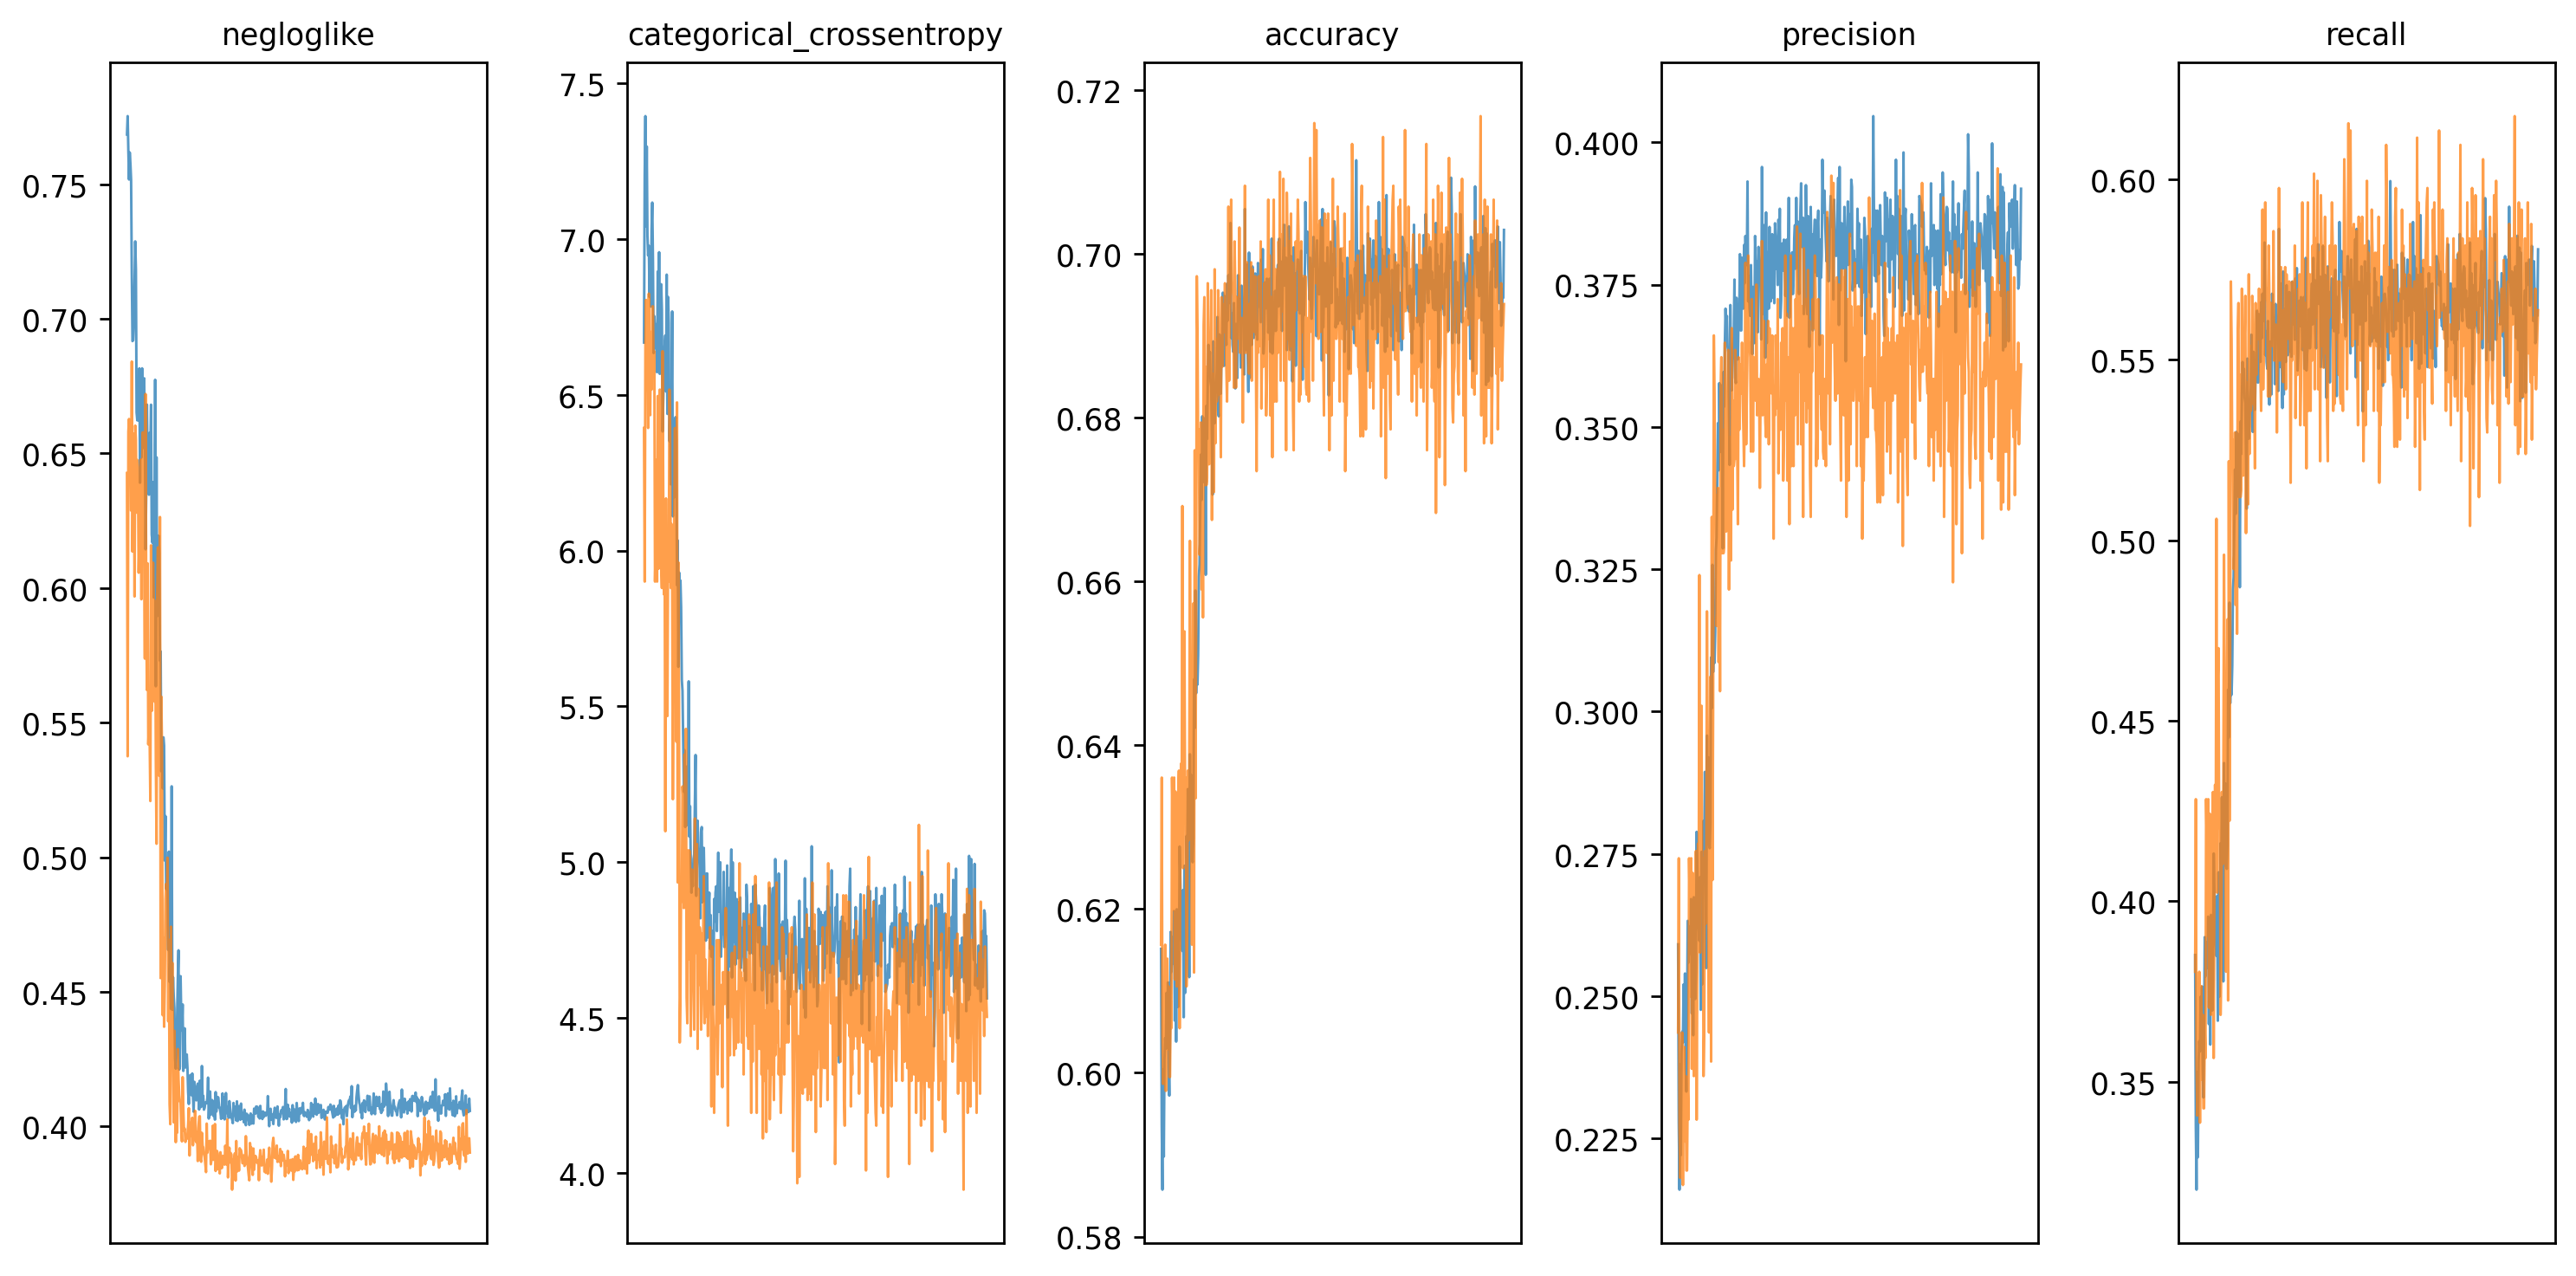

In [27]:
funs.metrics_plotter(history, ['loss','categorical_crossentropy','accuracy','precision','recall'], loss='negloglike')